# Titanic Machine Learning Project

### Add Imports

In [144]:
#Imports

#data imports
import pandas as pd
import numpy as np

#machine learning imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#just to hide warnings for certain models
import warnings


### Create the Dataframe

In [145]:
data = pd.read_csv("data/titanic.csv")
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Fill in missing ages

In [146]:
def fill_missing_ages(df):
    age_fill_map = {}
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass] = df[df["Pclass"] == pclass]["Age"].median()

    df["Age"] = df.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)


### Data Cleaning and Feature Engineering

In [147]:
def preprocess_data(df):
    # Delete all Columns/data aren't relevant for what we're trying to accomplish
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"], inplace=True)

    #Fill in missing data from Embarked
    # df["Embarked"].fillna("S", inplace=True)
    # df.drop(columns=["Embarked"], inplace=True)
    
    fill_missing_ages(df)

    # Convert Gender to binary for machine learning
    df["Sex"] = df["Sex"].map({"male":0, "female":1})

    # Feature Engineering: Creating new columns in our data to help enhance the model
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df["IsAlone"] = np.where(df["FamilySize"] == 0, 1, 0)
    df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0,12,20,40,60, np.inf], labels=False)

    return df




### Update and check the Data

In [148]:
data = preprocess_data(data)

# Features for Linear Models (Logistic Regression)
features_linear = ["Pclass", "Sex", "Age", "Fare", "FamilySize", "IsAlone"]

# Features for Tree-Based Models or KNN
features_tree = ["Pclass", "Sex", "AgeBin", "FareBin", "FamilySize", "IsAlone"]

#display(data.head(10))
display(data.sample(10))
#display(data.tail(10))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FareBin,AgeBin
426,1,2,1,28.0,1,0,26.0000,1,0,2,2
455,1,3,0,29.0,0,0,7.8958,0,1,0,2
731,0,3,0,11.0,0,0,18.7875,0,1,2,0
482,0,3,0,50.0,0,0,8.0500,0,1,1,3
690,1,1,0,31.0,1,0,57.0000,1,0,3,2
371,0,3,0,18.0,1,0,6.4958,1,0,0,1
495,0,3,0,24.0,0,0,14.4583,0,1,2,2
862,1,1,1,48.0,0,0,25.9292,0,1,2,3
714,0,2,0,52.0,0,0,13.0000,0,1,1,3
171,0,3,0,4.0,4,1,29.1250,5,0,2,0


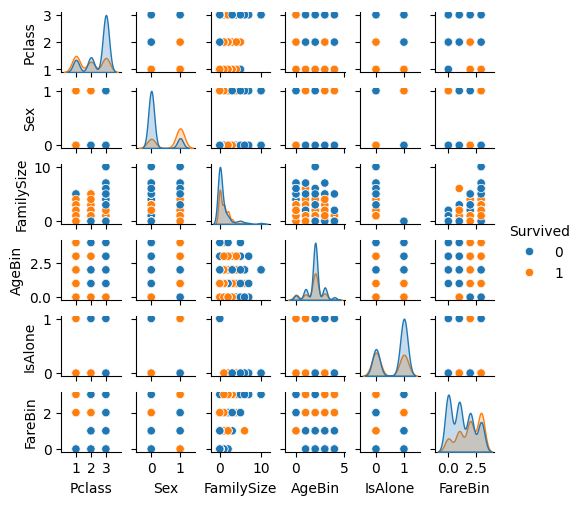

In [149]:
numeric_cols = ["Survived", "Pclass", "Sex", "FamilySize", "AgeBin", "IsAlone", "FareBin"]
sns.pairplot(data[numeric_cols], hue="Survived", height=0.85)

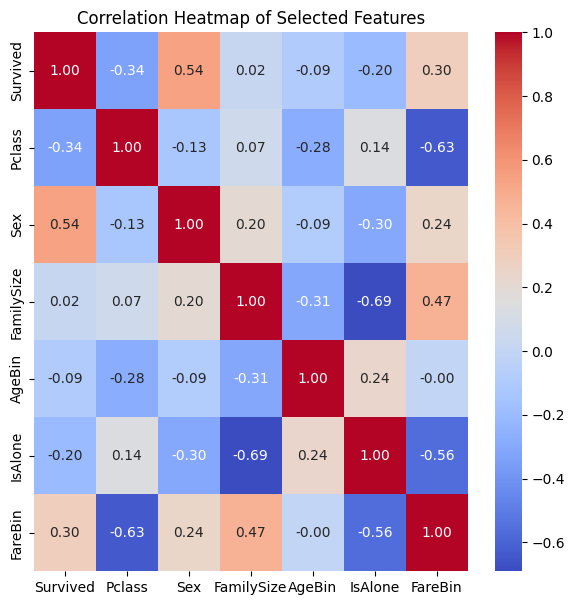

In [150]:
plt.figure(figsize=(7,7))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

## Create Features / Target Variables (Make Flashcards)
### ML Preprocessing
When we take our data and we make sure it's numerically formatted for the model to understand

In [ ]:
# X = data[features_linear]
# y = data["Survived"]
X = data.drop(columns=["Survived"])
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_linear = X_train[features_linear]
X_train_tree = X_train[features_tree]
X_test_linear = X_test[features_linear]
X_test_tree = X_test[features_tree]


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_linear_scaled = scaler.fit_transform(X_train_linear)
X_test_linear_scaled = scaler.transform(X_test_linear)
X_train_tree_scaled = scaler.fit_transform(X_train_tree)
X_test_tree_scaled = scaler.transform(X_test_tree)



# At this point, I have 6 train/test options of inputs I can give to any given model
#    - X_train
#    - X_train_scaled
#    - X_train_linear
#    - X_train_linear_scaled
#    - X_train_tree
#    - X_train_tree_scaled

## Hyperparameter Tuning - KNN

In [152]:
def tune_model(X_train_tree, y_train):
    param_grid = {
        "n_neighbors":range(1,21),
        "metric" : ["euclidean", "manhetten", "minkowski"],
        "weights" : ["uniform", "distance"]
    }

    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_tree, y_train)
    return grid_search.best_estimator_

warnings.filterwarnings("ignore")
best_model = tune_model(X_train_tree, y_train)

## KNN Evaluation and Modeling

In [153]:
def evaluate_model(model, X_test_tree, y_test):
    prediction = model.predict(X_test_tree)
    accuracy = accuracy_score(y_test, prediction)
    matrix = confusion_matrix(y_test, prediction)
    return accuracy, matrix

accuracy, matrix = evaluate_model(best_model, X_test_tree, y_test)

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Confusion Matrix:')
print(matrix)

Accuracy: 82.06%
Confusion Matrix:
[[124  10]
 [ 30  59]]


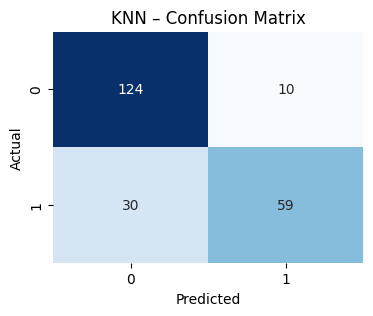

In [154]:
plt.figure(figsize=(4, 3))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN – Confusion Matrix")
plt.show()


## Train & Basic Score for Logistic Regression

In [155]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 30, 50],
    "penalty": ["l2"],           # with lbfgs/Saga, l2 only (l1 needs liblinear/saga)
    "solver": ["lbfgs", "liblinear"]          # try "liblinear" for small datasets
}
gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=10, scoring="roc_auc", n_jobs=-1)
gs.fit(X_train_tree, y_train)

best_logreg = gs.best_estimator_
print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", gs.best_score_)
print("Test ROC-AUC:", roc_auc_score(y_test, best_logreg.predict_proba(X_test_tree)[:,1]))

y_pred = best_logreg.predict(X_test_tree)
accuracy = accuracy_score(y_test, y_pred)
print(f'"Test Accuracy:" {accuracy*100:.2f}%')


Best params: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
CV best ROC-AUC: 0.84322138836773
Test ROC-AUC: 0.8860892168371626
"Test Accuracy:" 79.82%


### Confusion Matrix and ROC Curve for Logistic Regression

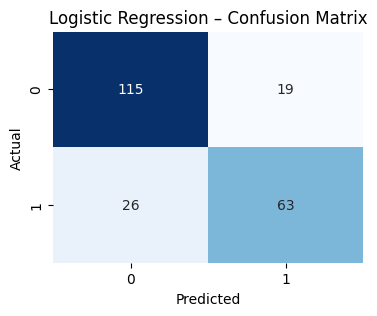

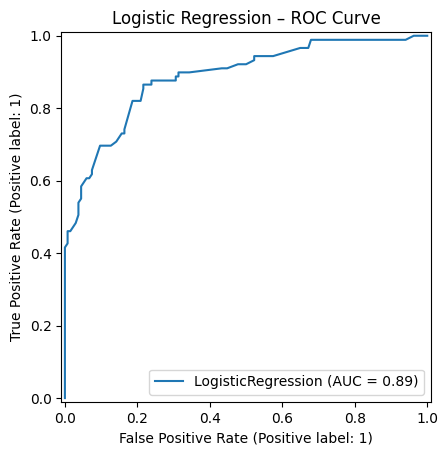

In [156]:
# Predictions
y_pred = best_logreg.predict(X_test_tree)
y_prob = best_logreg.predict_proba(X_test_tree)[:, 1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

# --- ROC Curve ---

RocCurveDisplay.from_estimator(best_logreg, X_test_tree, y_test)
plt.title("Logistic Regression – ROC Curve")
plt.show()